Student Details

Name: Sean McNamara

ID: 20329733

### Lab 5: Regression and Dimensionality Reduction

Introducing dimensionality reduction into the process of training and comparing predictive models (i.e., classification and regression models)

This exercise repeats the same scenario as Lab 4, but this time we train a regression model, i.e. a model for numeric prediction. We also add dimensionality reduction element to the training pipeline. Note that dimensionality reduction can be included in classification pipelines in the same way. In this exercise we use the insurance.csv dataset.

In this exercise, we aim at training a regression model. We will evaluate three regression algorithms, RandomForestRegressor and LinearRegression, & Ridge Regression to choose the better one for training the final model.

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### EDA

We start with a brief EDA to check for missing values and outliers.

In [4]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [5]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

Let's examine values in the categorical column Region first.

In [6]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [7]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [8]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

 Now, let's check for missing values and outliers.

In [9]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [10]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

In [11]:
df[df.children == 0]

age  gender     bmi  children smoker     region  insurance_cost
1      18    male  34.100         0     no  southeast      1137.01100
2      18  female  26.315         0     no  northeast      2198.18985
4      18  female  35.625         0     no  northeast      2211.13075
6      18  female  30.115         0     no  northeast     21344.84670
7      18    male  23.750         0     no  northeast      1705.62450
...   ...     ...     ...       ...    ...        ...             ...
1331   64  female  39.700         0     no  southwest     14319.03100
1332   64  female  35.970         0     no  southeast     14313.84630
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1337   64    male  23.760         0    yes  southeast     26926.51440

[574 rows x 7 columns]

From these results above you can see that there is quite a lot of couples with no children.

Now we can take look at the numerical values for outliers - we can first drop insurance from the boxplot as its a different scale

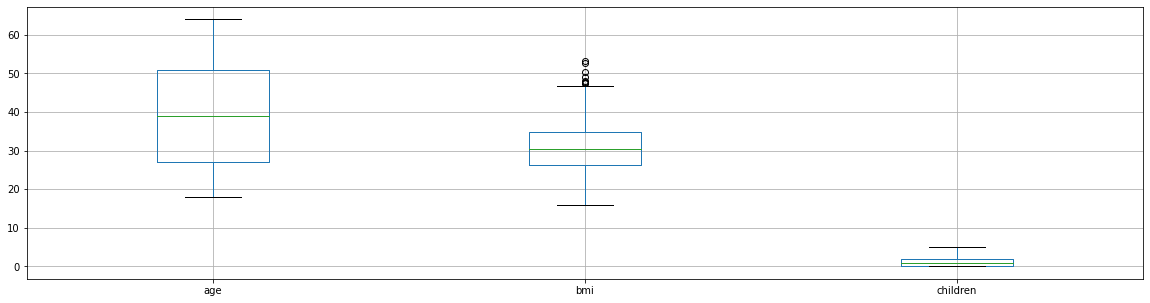

In [12]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

We should now take a look at insurance_cost.

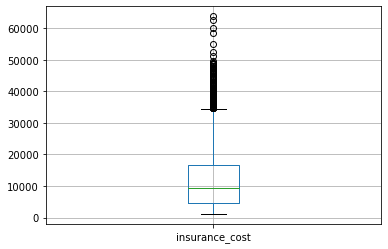

In [13]:
df.boxplot(column=['insurance_cost'])
plt.show()

In [14]:
df.sort_values(by=['insurance_cost'], ascending=False)

age  gender     bmi  children smoker     region  insurance_cost
1079   54  female  47.410         0    yes  southeast     63770.42801
837    45    male  30.360         0    yes  southeast     62592.87309
1035   52    male  34.485         3    yes  northwest     60021.39897
458    31  female  38.095         1    yes  northeast     58571.07448
512    33  female  35.530         0    yes  northwest     55135.40209
...   ...     ...     ...       ...    ...        ...             ...
1      18    male  34.100         0     no  southeast      1137.01100
35     18    male  33.660         0     no  southeast      1136.39940
60     18    male  33.330         0     no  southeast      1135.94070
41     18    male  30.140         0     no  southeast      1131.50660
47     18    male  23.210         0     no  southeast      1121.87390

[1338 rows x 7 columns]

From the data above there seesm to be a correllation between age & bmi - this could explain the predicted insurance cost. (Smoker could also have an effect.)

In [15]:
df.sort_values(by=['bmi'], ascending=False)

age  gender     bmi  children smoker     region  insurance_cost
66     18    male  53.130         0     no  southeast      1163.46270
215    22    male  52.580         1    yes  southeast     44501.39820
236    23    male  50.380         1     no  southeast      2438.05520
1177   58    male  49.060         0     no  southeast     11381.32540
845    46  female  48.070         2     no  northeast      9432.92530
...   ...     ...     ...       ...    ...        ...             ...
617    37  female  17.290         2     no  northeast      6877.98010
315    26  female  17.195         2    yes  northeast     14455.64405
173    21  female  16.815         1     no  northeast      3167.45585
647    38    male  16.815         2     no  northeast      6640.54485
10     18    male  15.960         0     no  northeast      1694.79640

[1338 rows x 7 columns]

Next, we will replace the categorical column region, gender, smoker to numerical columns.

In [16]:
df = pd.get_dummies(df, columns=['region','gender','smoker'], 
                        #dummy_na=True, 
                        drop_first=True)
df.head()

age     bmi  children  insurance_cost  region_northwest  region_southeast  \
0   18  33.770         1      1725.55230                 0                 1   
1   18  34.100         0      1137.01100                 0                 1   
2   18  26.315         0      2198.18985                 0                 0   
3   18  38.665         2      3393.35635                 0                 0   
4   18  35.625         0      2211.13075                 0                 0   

   region_southwest  gender_male  smoker_yes  
0                 0            1           0  
1                 0            1           0  
2                 0            0           0  
3                 0            0           0  
4                 0            0           0

In [17]:
df.tail()

age     bmi  children  insurance_cost  region_northwest  \
1333   64  31.825         2     16069.08475                 0   
1334   64  26.885         0     29330.98315                 1   
1335   64  26.410         0     14394.55790                 0   
1336   64  36.960         2     49577.66240                 0   
1337   64  23.760         0     26926.51440                 0   

      region_southeast  region_southwest  gender_male  smoker_yes  
1333                 0                 0            0           0  
1334                 0                 0            0           1  
1335                 0                 0            1           0  
1336                 1                 0            1           1  
1337                 1                 0            1           1

### Data Preparation

Let's examine the transformed dataset.

Since there are no obvious outliers, we will apply StandardScaler to all predictor columns witha very simple (compared to example A) pre-pocessing pipeline.

In [18]:
preprocess_pipeline = make_pipeline(StandardScaler())

In [19]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### TASK 1

### Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train (Random Forest), (Linear), & (Ridge) on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and (RFR), (LR), & (RR).

Note that RF is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

We limit the parameter grid to a few options for the max_depth parameter of RandomForestRegressor and to alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [22]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used. 
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.858:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


### Linear  Regression Pipeline

In [26]:
lr = LinearRegression()
lr.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [27]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used.
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.742:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__normalize': True}


###  Ridge Regression Pipeline

In [28]:
from sklearn import linear_model
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ridge', linear_model.Ridge())
                      ])
                       #('svr', svm.SVR())])
                       

N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
SOLVERS = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
                       
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ridge__solver': SOLVERS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ridge__solver': SOLVERS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used.
RIDGE_best_params = search.best_params_
RIDGE_best_model = search.best_estimator_

Best CV score = 0.742:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'ridge__solver': 'saga'}


### Comparing the Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:
mean squared error (MSE)
mean absolute error (MAE)
1-relative squared error (R2)

To choose the better regressor for our problem. We will use the function above to evaluate the best models found by the grid search.

In [29]:
# A trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute prediction for the test set
    _predicted_values = model.predict(X_test)
        
    # compute the metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [30]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
RIDGE_mse, RIDGE_mae, RIDGE_r2 = evaluate_model(X_test, y_test, RIDGE_best_model)
print("RF: ",RF_mse, RF_mae, RF_r2)
print("LR: ",LR_mse, LR_mae, LR_r2)
print("RIDGE: ",RIDGE_mse, RIDGE_mae, RIDGE_r2)

RF:  19487050.740787737 2639.9943188278517 0.8581536572225483
LR:  32300325.114165675 3721.659282926117 0.7648857670197728
RIDGE:  32301440.646932885 3722.6147655936543 0.7648776470510109


Next we will use a Pandas bar plots to compare the results.

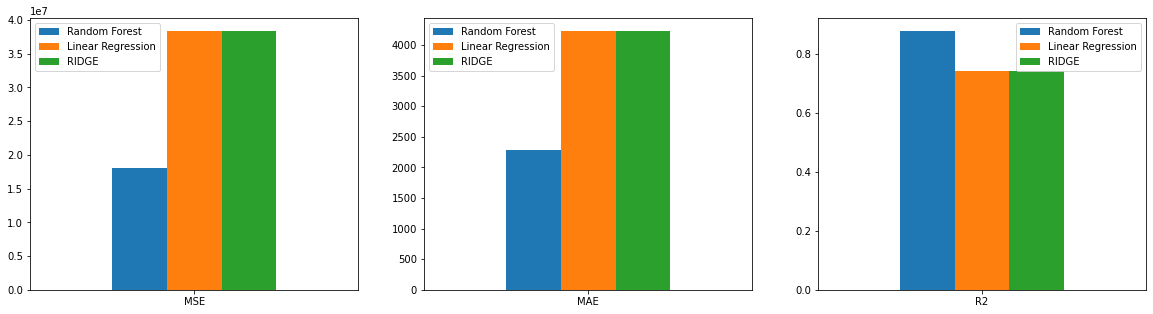

In [59]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'RIDGE': RIDGE_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'RIDGE': RIDGE_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'RIDGE': RIDGE_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

From running this various times it indicates that Random Forest performs better (CV score 0.858). It is very interesting to capture Linear Regression & Ridge perform the same (CV score 0.742) in all three MSE, MAE & R2. 

In [60]:
# function to remove the string 'regresson__' from the names of the best param.
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [61]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

### Task 2 

### Random Forest Regression with LDA and LLE

LinearDiscriminantAnalysis and LocallyLinearEmbedding for dimensionality reduction.

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding

In [63]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

# Random Forest
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

N_NEIGHBORS_OPTIONS = [2,6,11]

param_grid = [
    {
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_neighbors': N_NEIGHBORS_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used.
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.552:
Best parameters:  {'reduce_dim': LocallyLinearEmbedding(n_neighbors=11), 'reduce_dim__n_neighbors': 11, 'regresson__max_depth': 4}


### Ridge Regression with LDA and LLE

In [64]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ridge', linear_model.Ridge())])
#SVR
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
KERNEL_OPTIONS=['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

SOLVERS = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']

param_grid = [
    {
        'reduce_dim': [LinearDiscriminantAnalysis()],        
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ridge__solver': SOLVERS
    },
    {
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_neighbors': N_FEATURES_OPTIONS,
        'ridge__solver': SOLVERS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used.
RIDGE_best_params = search.best_params_
RIDGE_best_model = search.best_estimator_

Best CV score = 0.066:
Best parameters:  {'reduce_dim': LocallyLinearEmbedding(n_neighbors=11), 'reduce_dim__n_neighbors': 11, 'ridge__solver': 'cholesky'}


### Linear Regression with LDA and LLE

In [65]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

# Linear Regression

N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

N_NEIGHBORS_OPTIONS = [2,6,11]

param_grid = [
    {
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_neighbors': N_FEATURES_OPTIONS,
        'regresson__normalize': N_NEIGHBORS_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used.
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.088:
Best parameters:  {'reduce_dim': LocallyLinearEmbedding(n_neighbors=6), 'reduce_dim__n_neighbors': 6, 'regresson__normalize': 6}


In [66]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
RIDGE_mse, RIDGE_mae, RIDGE_r2 = evaluate_model(X_test, y_test, RIDGE_best_model)
RIDGE_mse, RIDGE_mae, RIDGE_r2

(142479579.9365306, 8980.886279203543, 0.04107531670691189)

Now we will use again a Pandas bar plots to compare the results. 

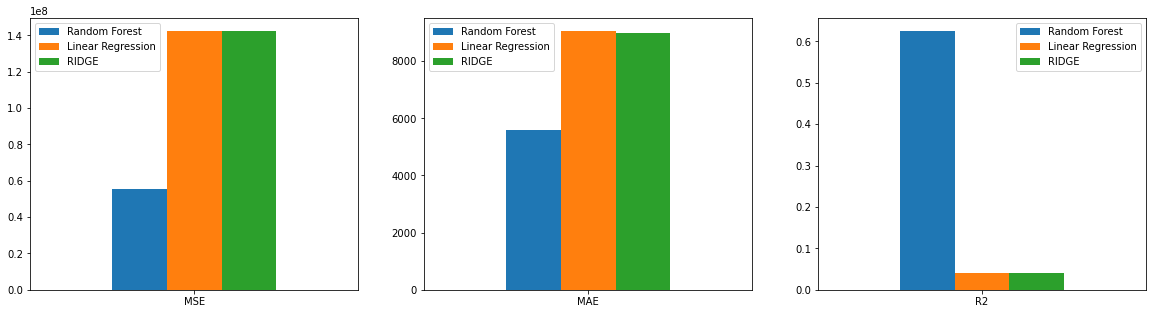

In [68]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'RIDGE': RIDGE_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'RIDGE': RIDGE_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'RIDGE': RIDGE_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

From running these results various times to get a good variation it seems Random Forest is performing the best out of Linear Regression and Ridge plus RF is particulary high in R2 and lower in MSE & MAE compared to Linear and Ridge. 
You can see that there is now a slight difference in MAE as Ridge is now 0.066 & Linear is at 0.088 on CV score. 

From task 1 to task2 - Random Forest has still come out on top. Even applying LinearDiscriminantAnalysis (LDA) and LocallyLinearEmbedding (LLE)

### Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have. 

In [31]:
#We can have a function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [32]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

Done-

Thanks for taking the time to go through my work.